In [75]:
# !unzip in_data/data-compressed.zip

In [9]:
#imports, need to only run this once
!pip3 install numpy 
!pip3 install pandas 
!pip3 install torch torchvision 
!pip3 install scikit-learn
!pip3 install xgboost
!pip3 install category_encoders
!pip3 install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.1/452.1 kB 2.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 52.8 MB/s eta 0:00:0000:0100:01


# Gradient Boosted Tree

In [6]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split

D_PATH = 'lish-moa/'

train_features = pd.read_csv(D_PATH + 'train_features.csv')
train_drug  = pd.read_csv(D_PATH + 'train_drug.csv')
test_features = pd.read_csv(D_PATH + 'test_features.csv')
train_targets_scored = pd.read_csv(D_PATH + 'train_targets_scored.csv' )
train_targets_nonscored = pd.read_csv(D_PATH + 'train_targets_nonscored.csv' )

tr_mask = train_features['cp_type']=='ctl_vehicle'
ts_mask = test_features['cp_type']=='ctl_vehicle'



#manually binarizing the category labels that are strings
train_features['cp_dose'] = train_features['cp_dose'].replace({'D1': 0, 'D2': 1})
train_features['cp_type'] = train_features['cp_type'].replace({'trt_cp': 0, 'ctl_vehicle': 1})
test_features['cp_dose'] = test_features['cp_dose'].replace({'D1': 0, 'D2': 1})
test_features['cp_type'] = test_features['cp_type'].replace({'trt_cp': 0, 'ctl_vehicle': 1})

# Exclude rows where cp_type is "ctl_vehicle"
COMPLETE_X = train_features[~tr_mask]
COMPLETE_y = train_targets_scored[~tr_mask]


#removing sig_id column, will also remove column header
X = COMPLETE_X.iloc[:, 1:].to_numpy()
submission_X_test = test_features.iloc[:, 1:].to_numpy() #only for the final submission
y = COMPLETE_y.iloc[:, 1:].to_numpy()

#we are going to fake making a train, dev and test set 
'''
X -> training examples, 
X_test -> 30% of samples, is used in next line to further split into dev, 
y -> training labels, 
y_test -> used to split into dev
'''
X, X_test, y, y_test = train_test_split(X, y, test_size=0.8, random_state=42) 
# X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.333, random_state=42) #test_size is dev size of 0.3333

In [25]:
COMPLETE_X.head()

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2        0       24        0  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc        0       72        0  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a        0       48        0  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391        0       48        0 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3        0       72        1 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

min count: 1, max count: 832


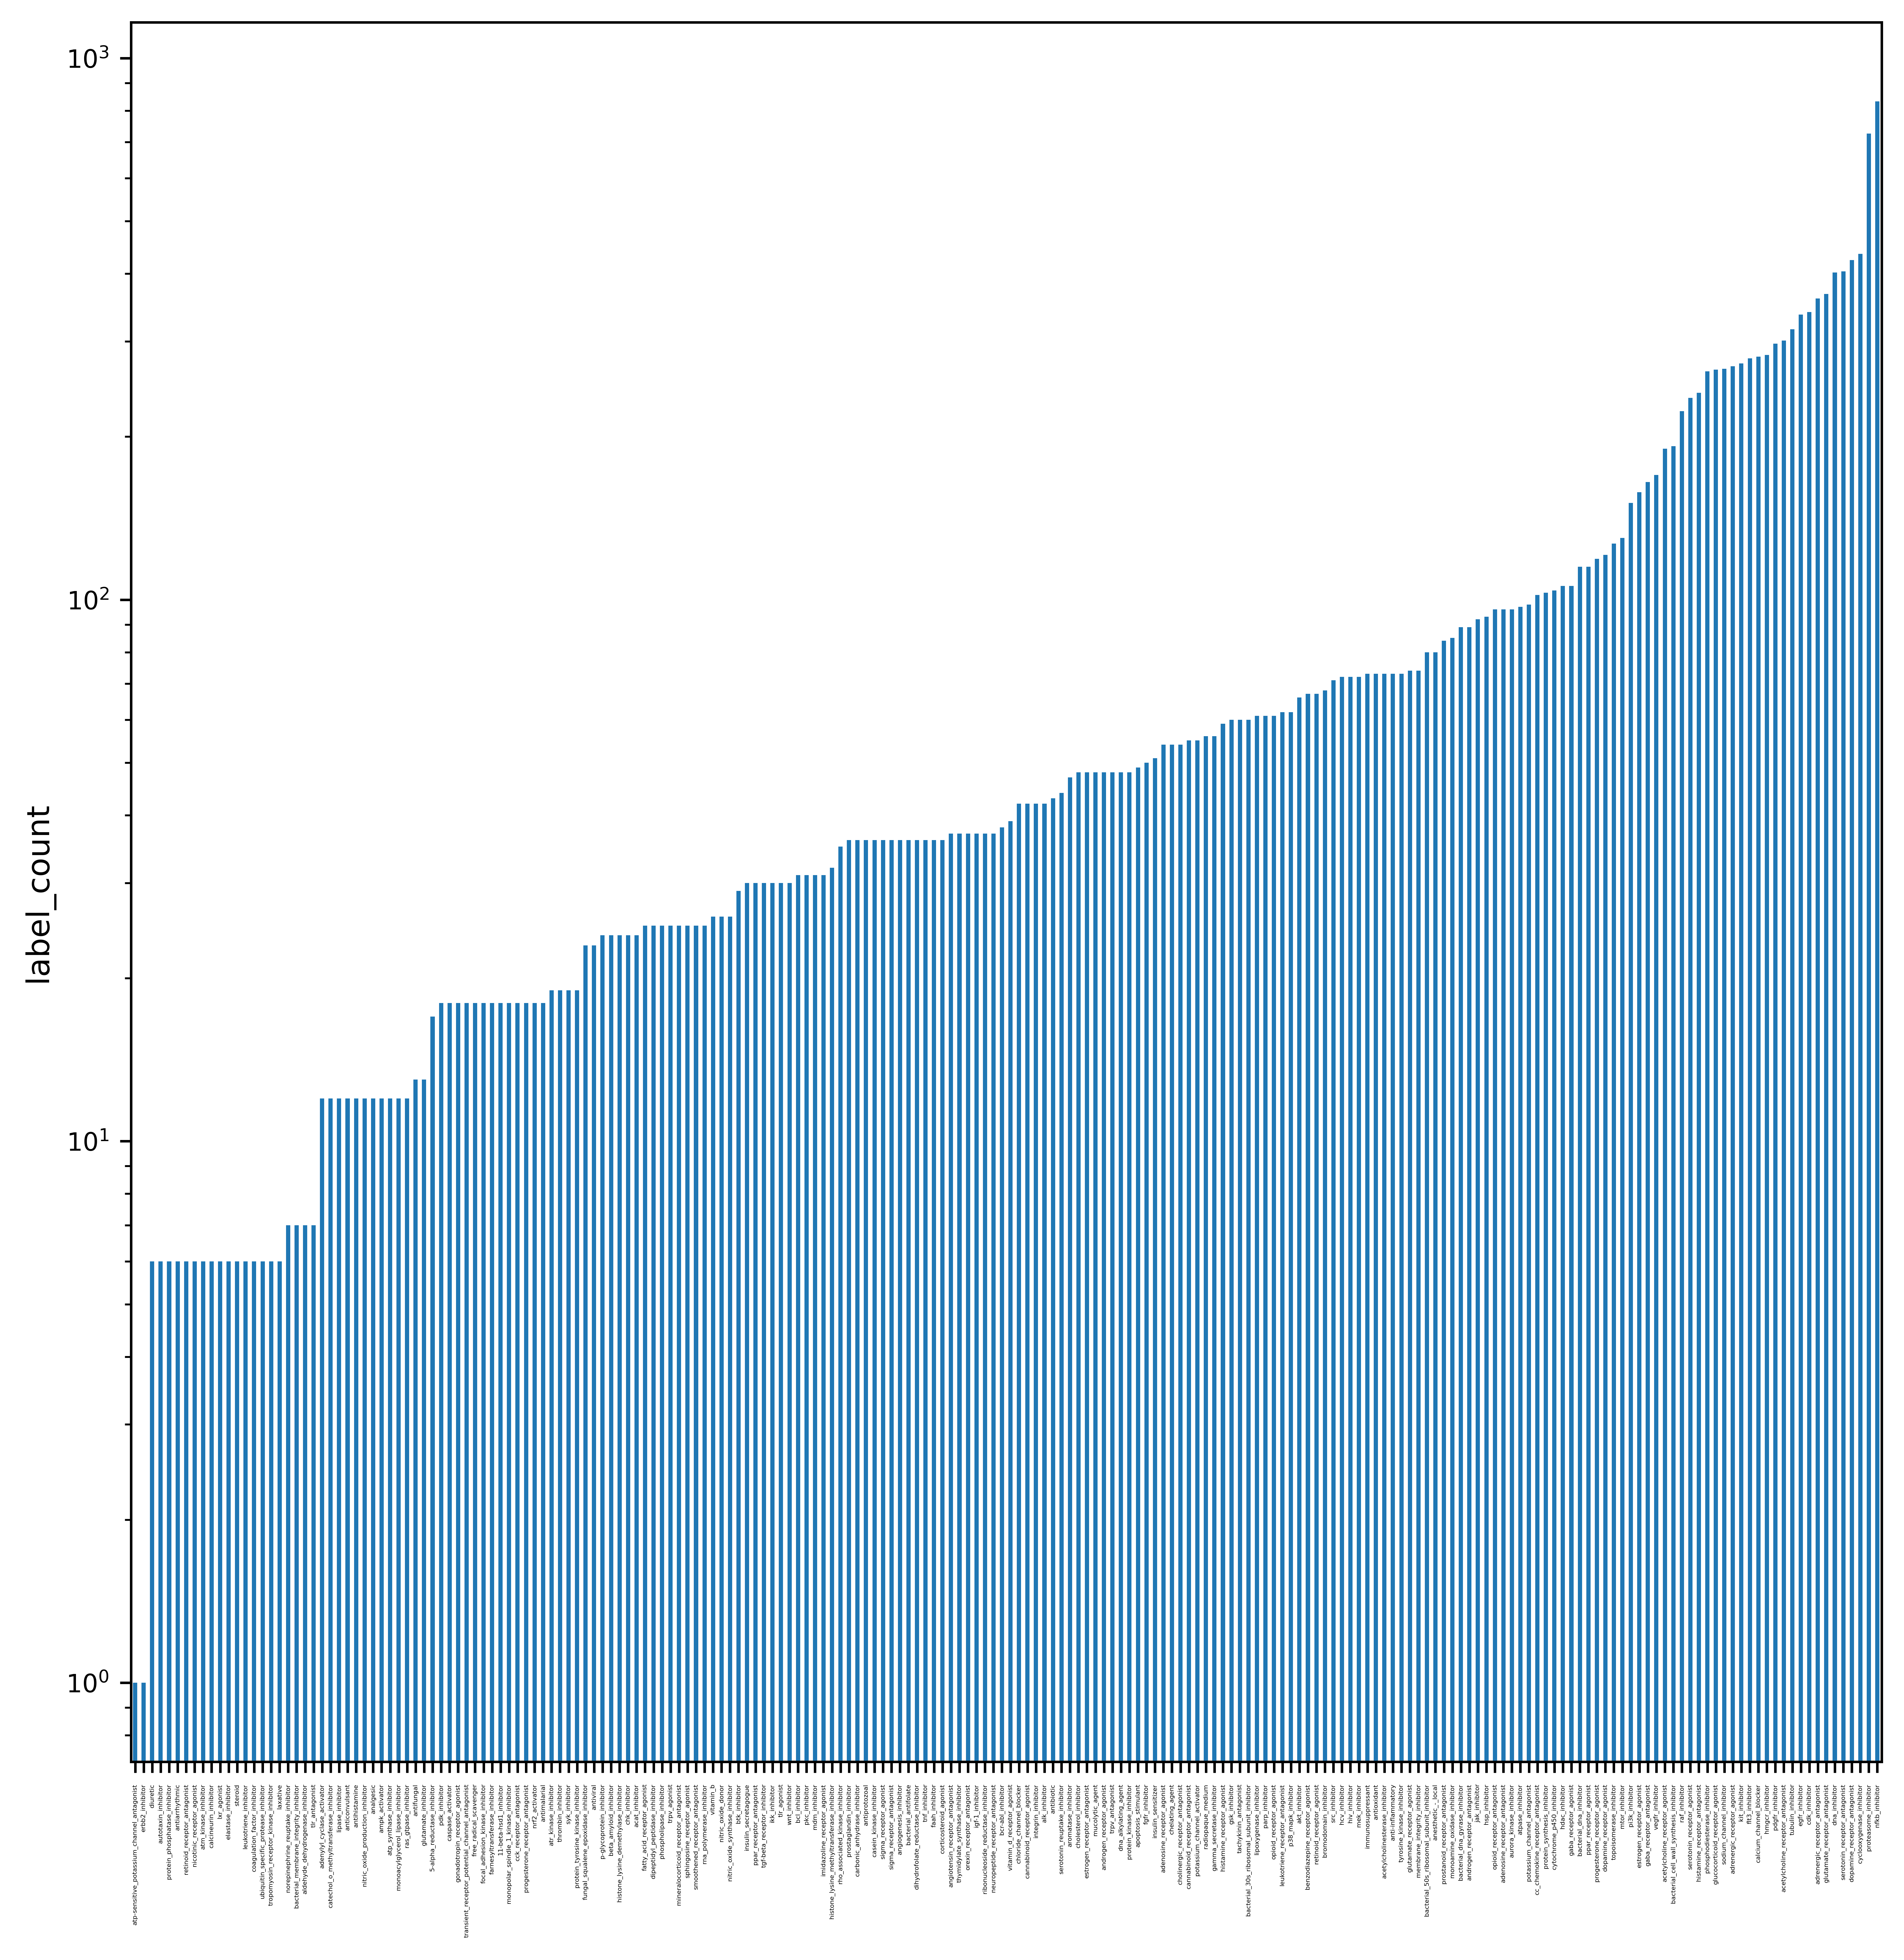

In [4]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 10), dpi=800) #create figure object with high DPI because there are lots of column labels 

col_sums = COMPLETE_y.sum(axis=0).iloc[1:].sort_values() #take col sums to find number of examples 

print(f'min count: {col_sums.min()}, max count: {col_sums.max()}') #output min and max count of labels

col_sums.plot.bar(ylabel='label_count', fontsize=2) #plot
plt.yticks(fontsize=8)
plt.yscale('log')


In [7]:
import os 
import sys
import numpy as np 
import pandas as pd 
from xgboost import XGBClassifier 
from sklearn.model_selection import KFold, RandomizedSearchCV 
from category_encoders import CountEncoder 
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, accuracy_score, classification_report, jaccard_score, make_scorer
from sklearn.multioutput import MultiOutputClassifier


n_folds = 8 #num folds for Kfold cross validation


'''
NO HYPERPARAMETER TUNING
- we use just vanilla kfold cv with default hyperparameters 
'''
xgb_classifier = MultiOutputClassifier(XGBClassifier()) #using sklearn's pipeline to build a multilabel, multiclass classifier
model = Pipeline([ 
                  ('classify', xgb_classifier)]) #instantiate the pipeline object

kf = KFold(n_splits = n_folds) #instantiate a kfold CV object 



oof_losses = []
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'fold: {fold_idx}')
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
   # Fit RandomizedSearchCV on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    val_preds = model.predict_proba(X_val)
    
    val_preds = np.array(val_preds)[:,:,1].T # take the positive class

    loss = log_loss(np.ravel(y_val), np.ravel(val_preds)) #using log loss here not jaccard
    print(f'loss: {loss}')

    oof_losses.append(loss)

#try on test set 
test_preds = model.predict_proba(X_test) #get predictions on test set
test_preds = np.array(test_preds)[:,:,1].T # take the positive class 
mat_y_preds = np.round(test_preds)

report = classification_report(np.ravel(y_test), np.round(np.ravel(test_preds)))
print(report)

fold: 0
loss: 0.02381562650048329
fold: 1
loss: 0.02437359653736463
fold: 2
loss: 0.02445569754926001
fold: 3
loss: 0.023402136759907516
fold: 4
loss: 0.023843872255325728
fold: 5
loss: 0.02327726473459224
fold: 6
loss: 0.02375379115293028
fold: 7
loss: 0.02329327666210759
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3603708
           1       0.94      0.17      0.30     13446

    accuracy                           1.00   3617154
   macro avg       0.97      0.59      0.65   3617154
weighted avg       1.00      1.00      1.00   3617154



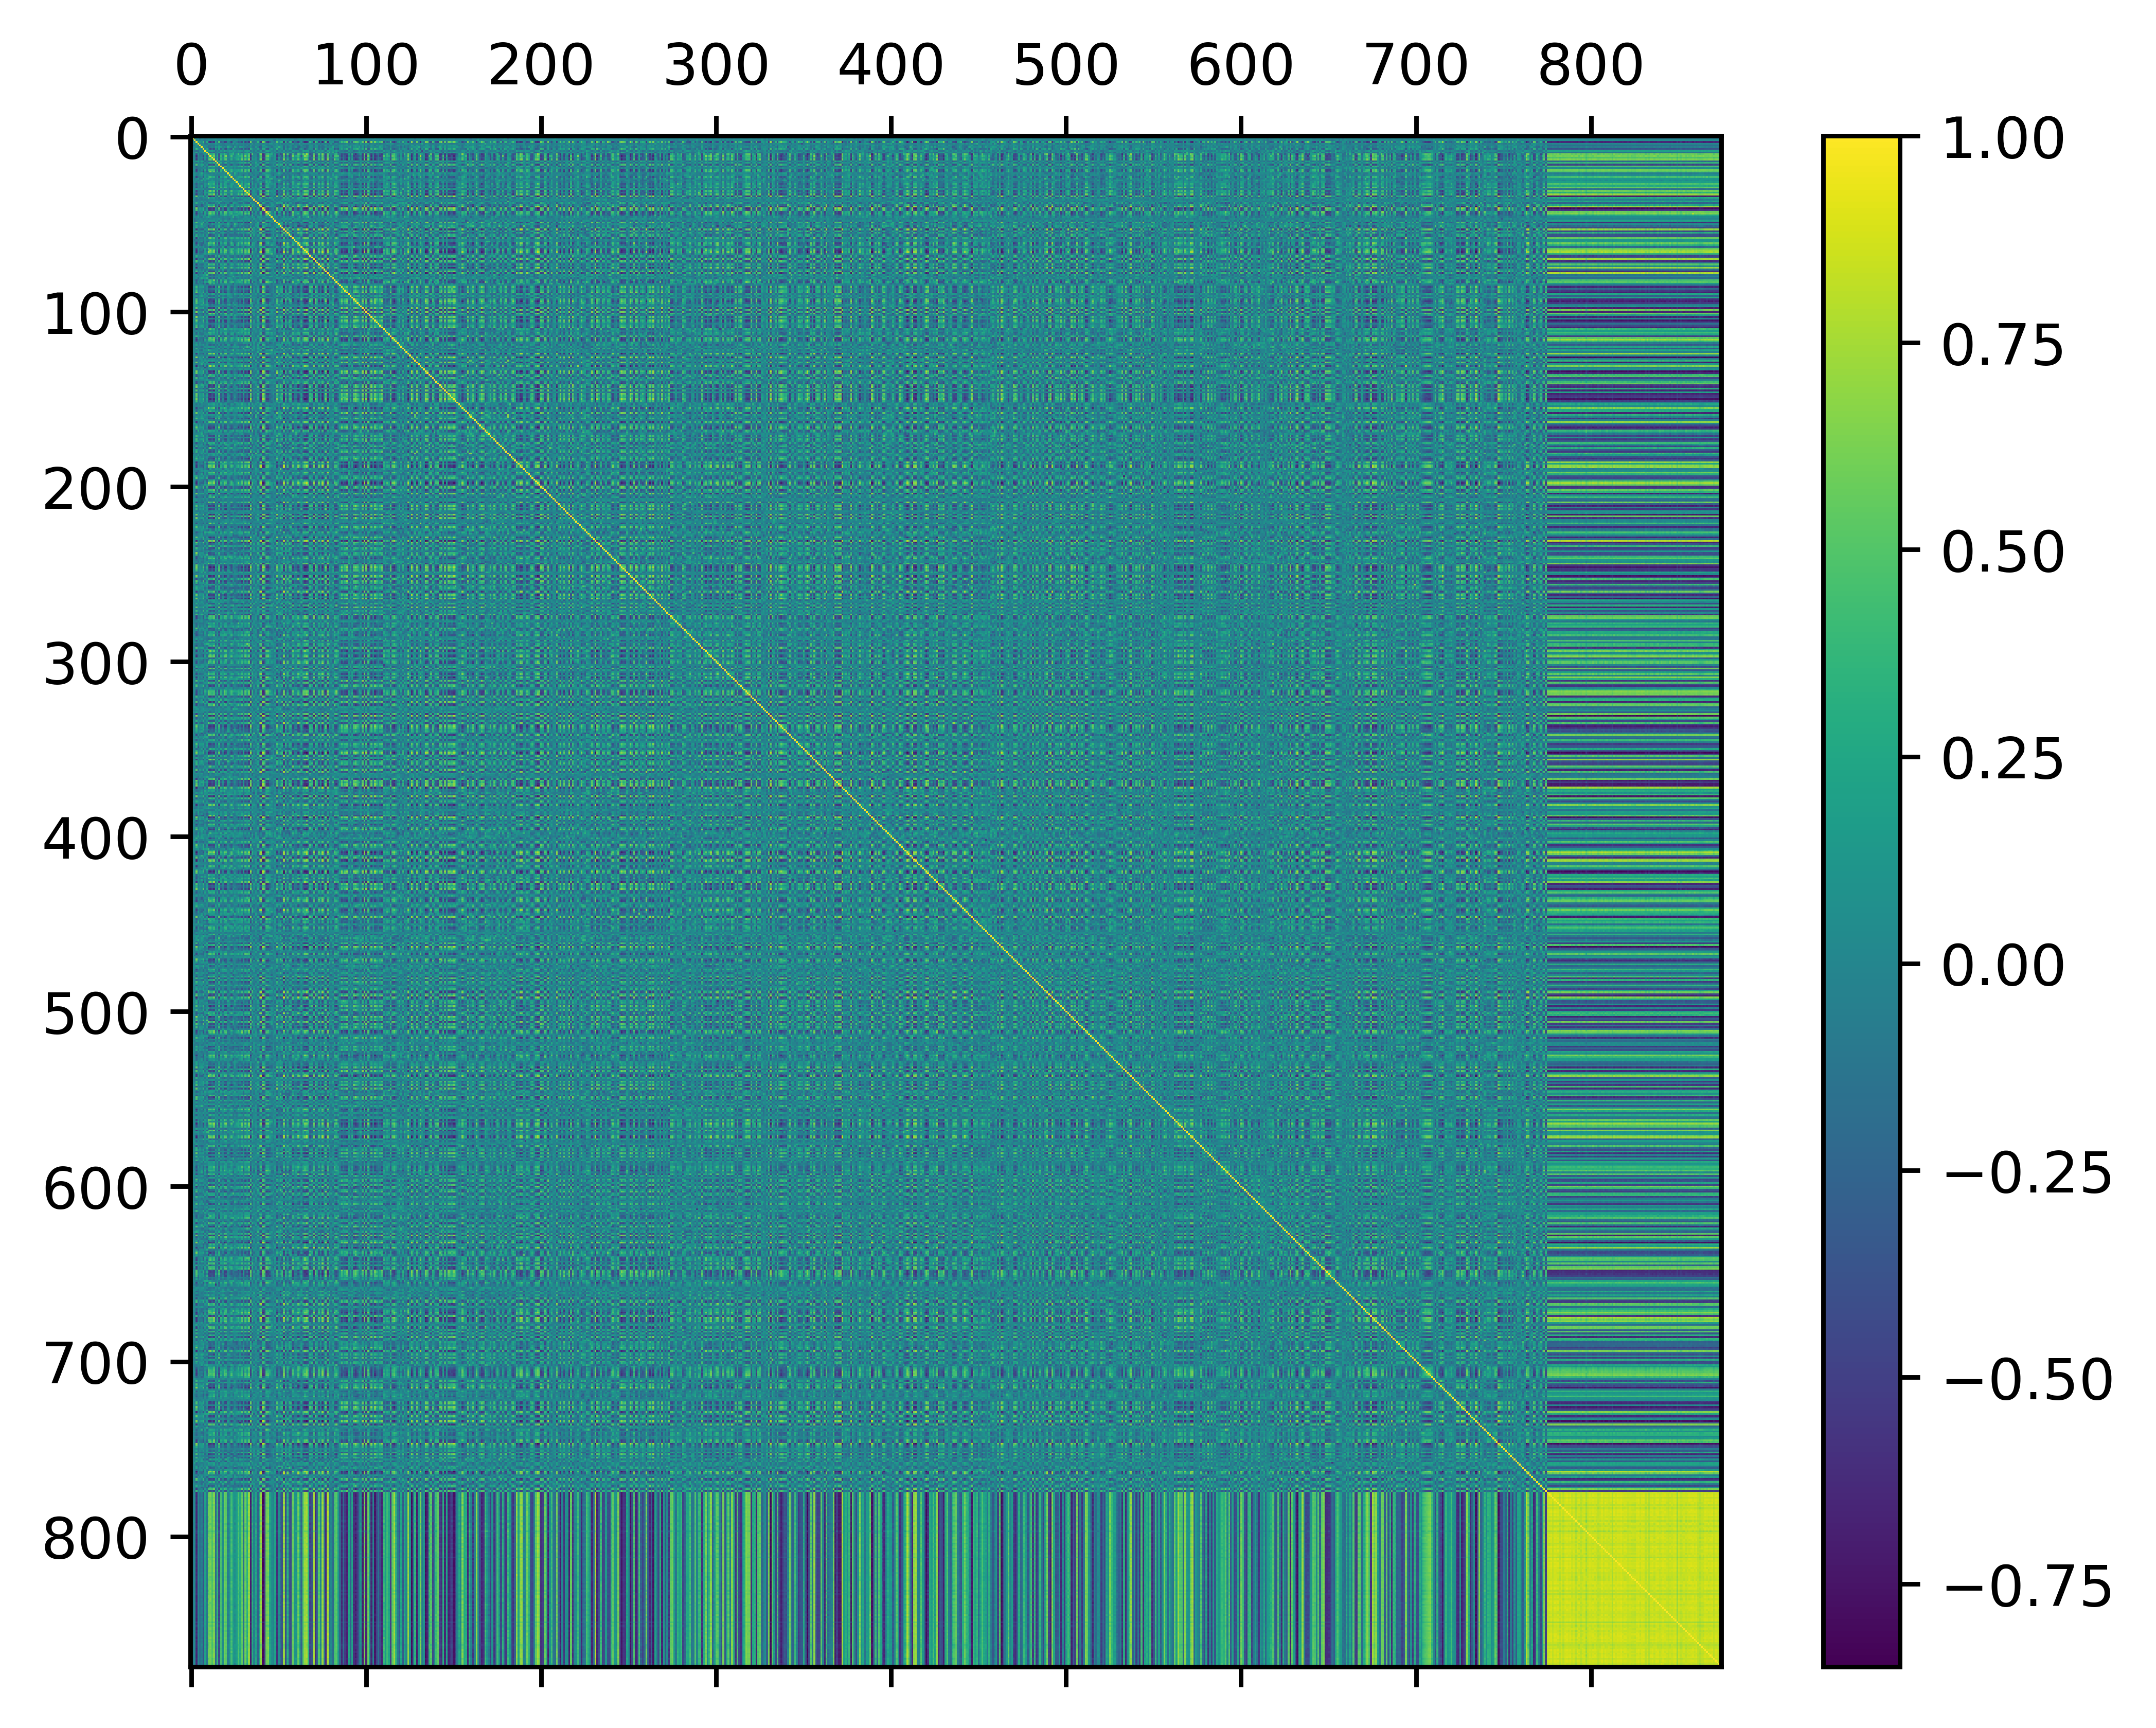

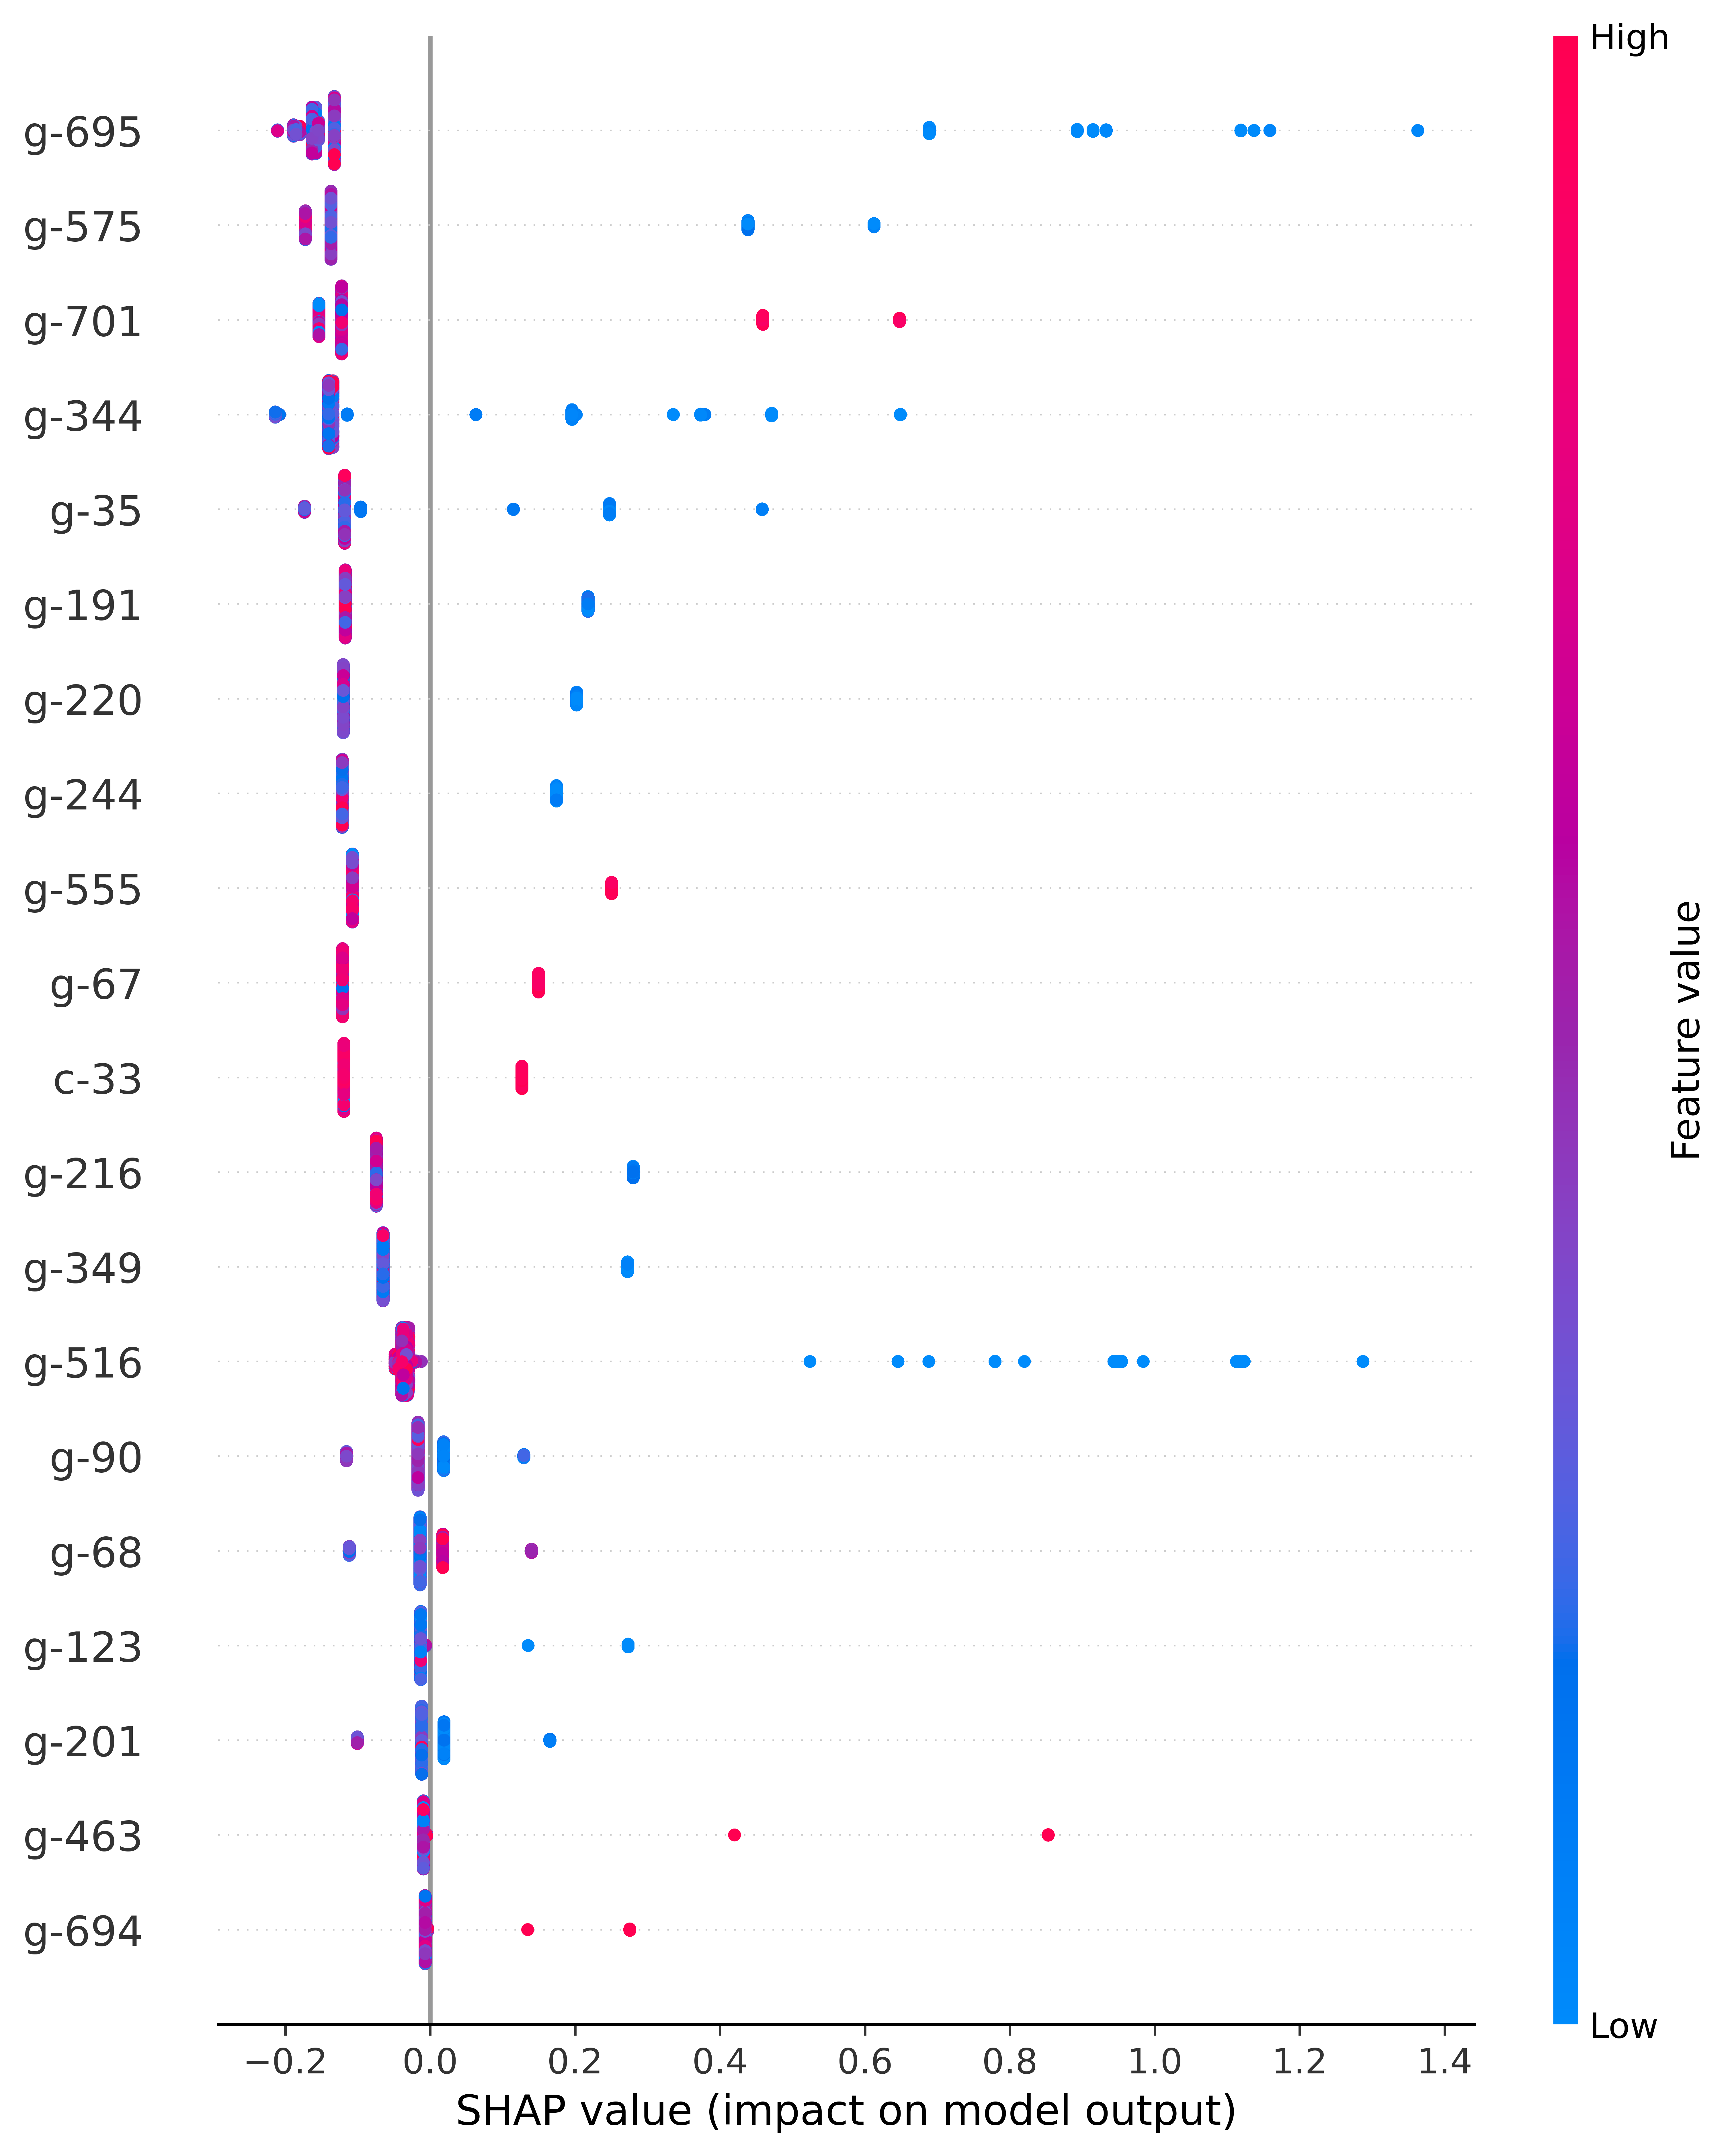

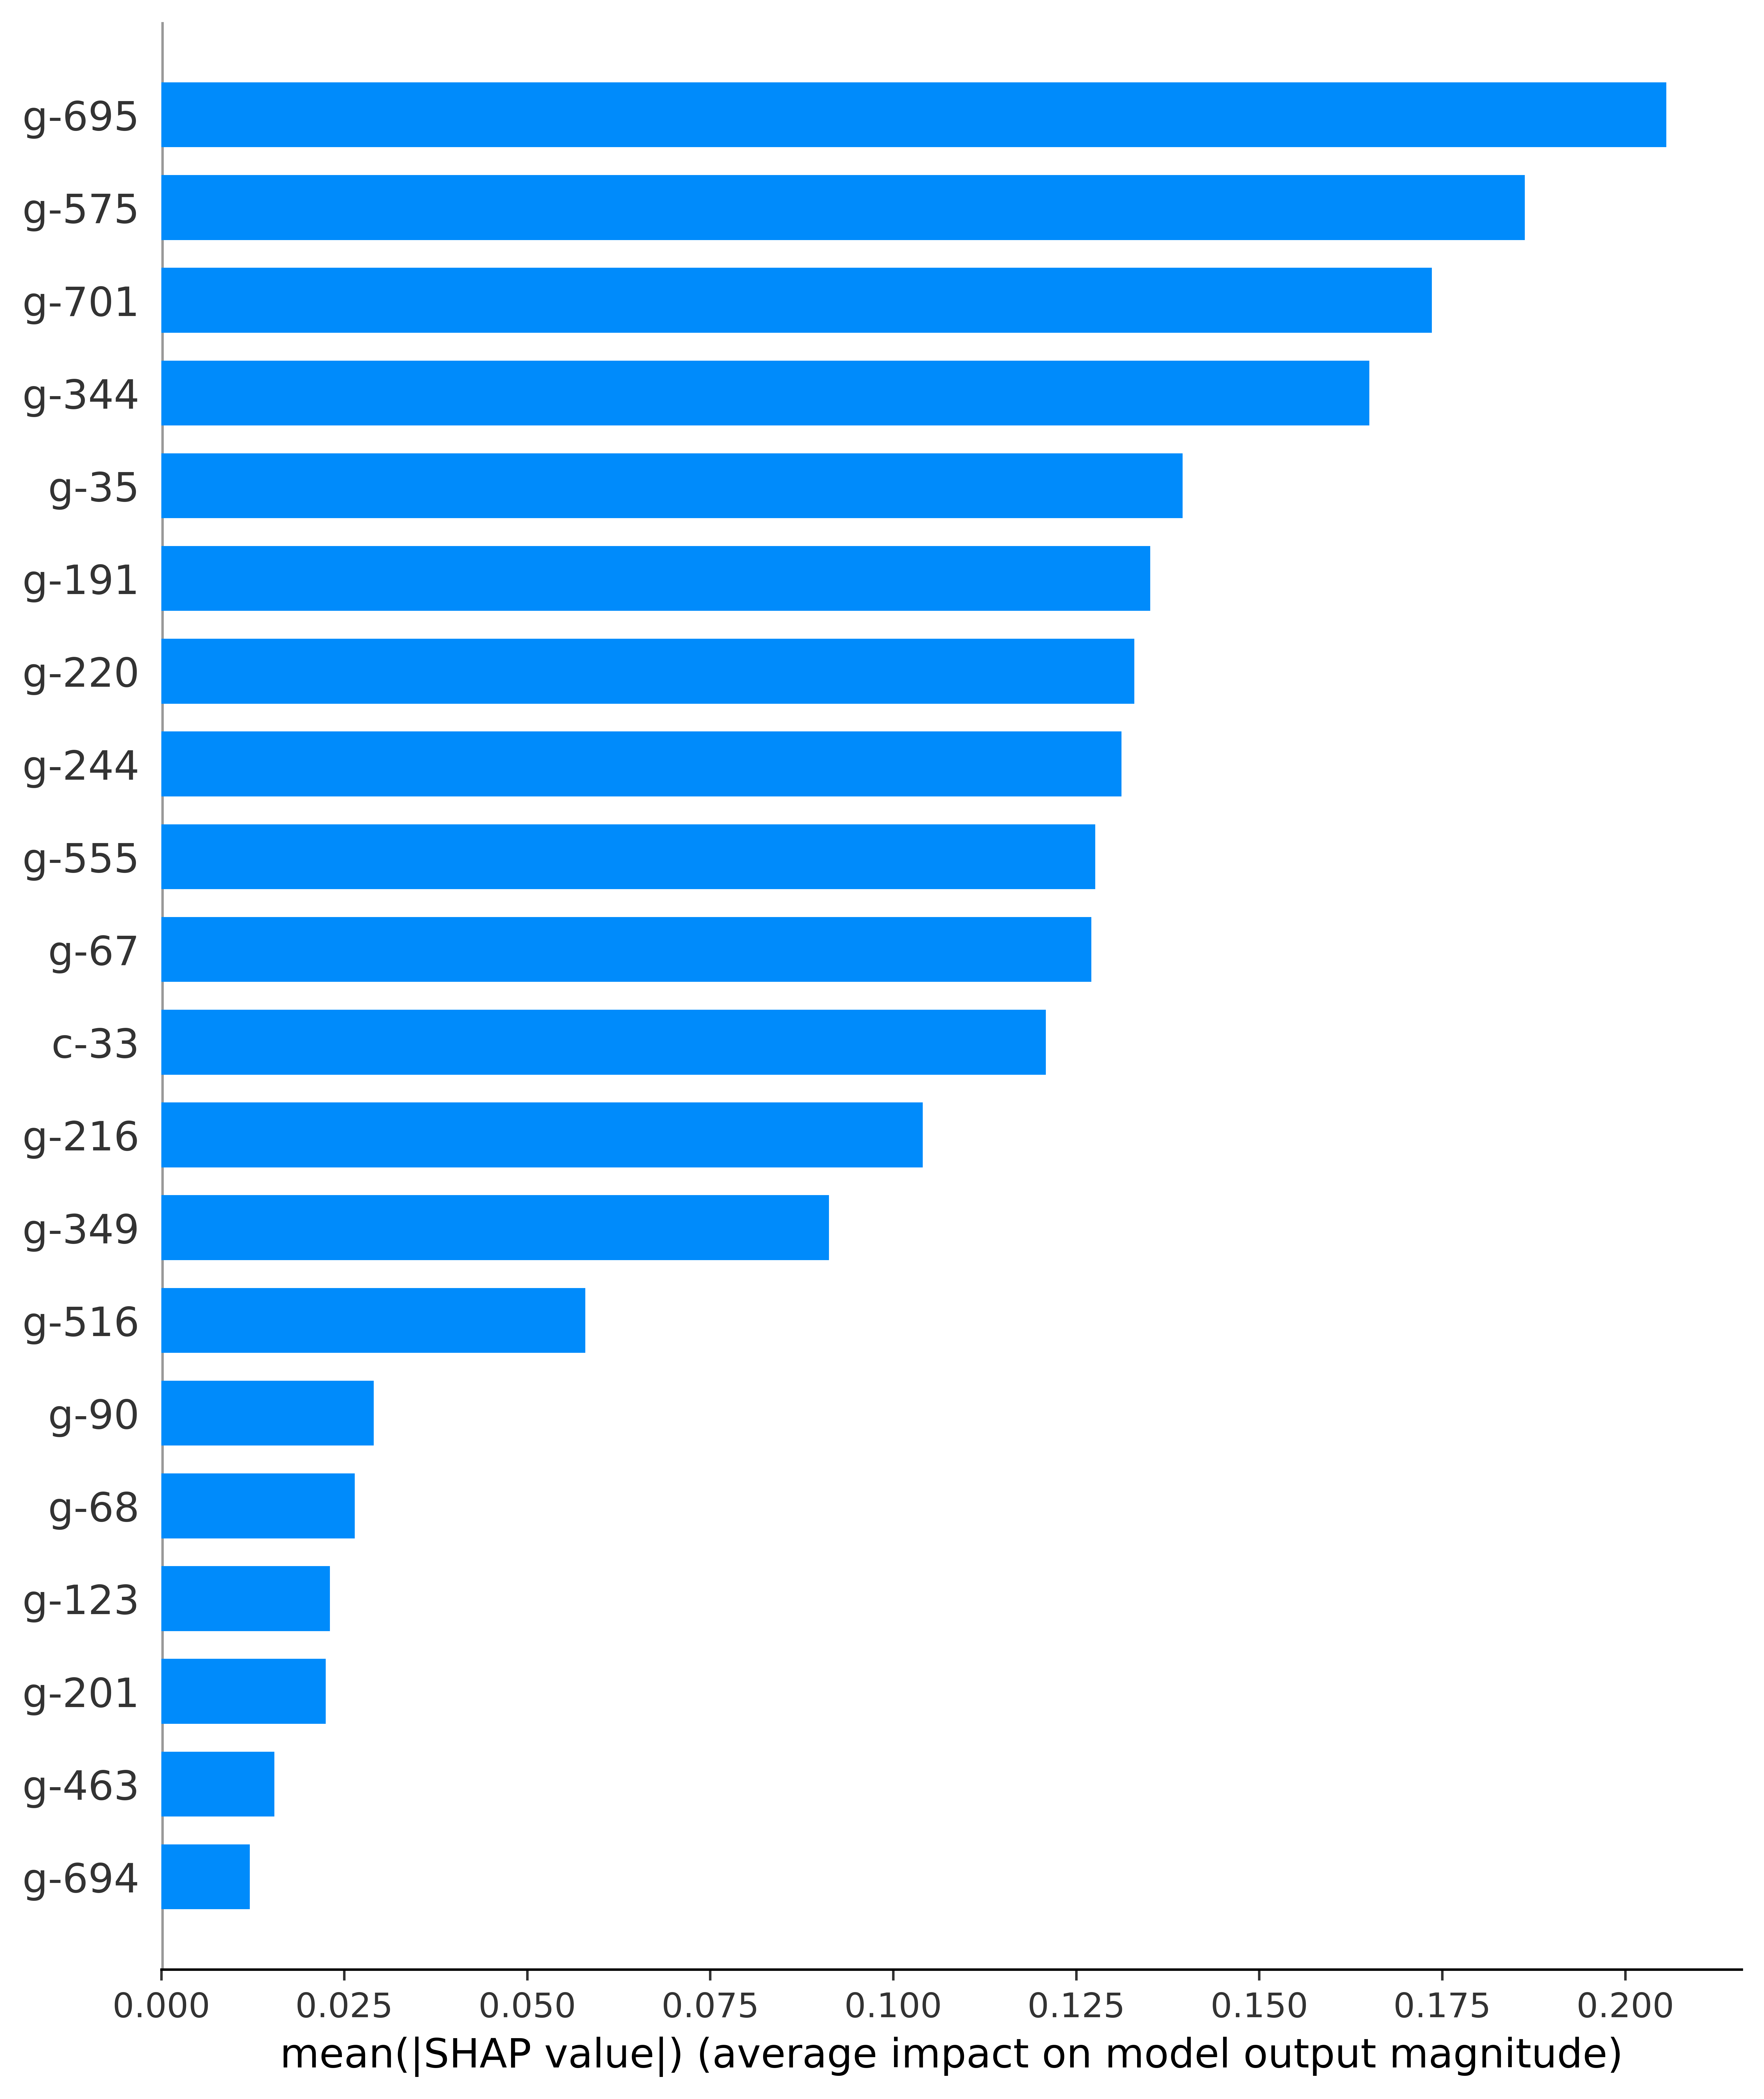

In [43]:
import shap 

#shap plot 
explainer = shap.TreeExplainer(model.named_steps['classify'].estimators_[87])
df_X = pd.DataFrame(X, columns=COMPLETE_X.columns[1::])
f = plt.figure(dpi=800)
plt.matshow(df_X.corr(), fignum=f.number)
plt.colorbar()
shap_values = explainer(df_X)
plt.figure(dpi=800)
shap.summary_plot(shap_values, X, show=False)
plt.figure(dpi=800)
shap.summary_plot(shap_values, df_X.values, plot_type="bar", class_names= df_X.columns, feature_names = df_X.columns)

# shap.plots.beeswarm(shap_values)


In [ ]:
'''
- parameter grid, we elect to modify the max_depth, learning_rate and n_estimators 
'''

'''GBT WITH HYPERPARAMETER TUNING'''

param_grid = {
    'classify__estimator__max_depth': np.linspace(0, 10, 11).astype(int),
    'classify__estimator__learning_rate': [10 ** -i for i in range(4)],
    'classify__estimator__n_estimators': [i*100 for i in range(5)]
}

xgb_classifier = MultiOutputClassifier(XGBClassifier()) #using sklearn's pipeline to build a multilabel, multiclass classifier

model = Pipeline([ 
                  ('classify', xgb_classifier)]) #instantiate the pipeline object

kf = KFold(n_splits = n_folds) #instantiate a kfold CV object 

'''
- We use random_search to not explore the whole parameter space, n_iter gives the number of param combinations used, can alternatively use GridSearchCV
- Jaccard scoring appears to be a good metric for a multilabel multiclass problem, can read more at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html
''' 

jaccard_scorer = make_scorer(jaccard_score, average='macro', zero_division=0.0) #define custom scoring function
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=1, cv=kf, scoring=jaccard_scorer, verbose=10, n_jobs=-1)
random_search.fit(X, y)# Fit RandomizedSearchCV on the training data
best_model = random_search.best_estimator_ # Get the best model from RandomizedSearchCV


test_preds = best_model.predict_proba(X_test) #get predictions on test set
test_preds = np.array(test_preds)[:,:,1].T # take the positive class 
mat_y_preds = np.round(test_preds)

report = classification_report(np.ravel(y_test), np.round(np.ravel(test_preds)))
print(report)


# Neural Network 